In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
import requests # API library

import random
import time
import os

from isoweek import Week

import requests # API library

import numpy as np
import pandas as pd
import json
import re

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive

import torch


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

my_data_path = "df_matches.csv"
df = pd.read_csv(my_data_path, sep=',')
# Drop rows with missing values
# df = df.dropna(subset=['match_date','match_conceded', 'coach1_CR', 'coach2_CR'])

relevant = ["match_id", "division_name", "match_date", "match_time", "match_conceded",
            "team1_coach_id", "team1_race_name", "team2_coach_id", "team2_race_name",
            "team1_score", "team2_score","team1_win","team2_win","mirror_match",
            "coach1_ranking","coach2_ranking","coach1_CR","coach2_CR", "team1_roster_id", "team2_roster_id"]
#irrelevant_columns = set(df.columns) - set(relevant)

irrelevant_columns = {
    'tournament_name', 'week_year', 'cr_diff2', 'team1_cas_bh',
    'group_name', 'team2_foul', 'team2_id', 'coach2_CR_bin',
    'team1_id', 'year', 'week_date', 'week_number', 'replay_id',
    'team1_cas_rip', 'tv_diff', 'team2_block', 'coach1_CR_bin',
    'has_sp', 'team2_value', 'tournament_type', 'team1_value',
    'team2_comp', 'team1_rush', 'team1_foul', 'team2_inducements',
    'tv_diff2', 'tournament_start', 'team2_cas_rip', 'team1_inducements',
    'tv_bin', 'scheduler', 'team1_comp', 'cr_diff2_bin', 'group_id',
    'division_id', 'tournament_id', 'Unnamed: 0', 'team2_cas_si',
    'current_ruleset', 'team2_cas', 'team2_rush', 'team1_block',
    'tournament_end', 'team2_pass', 'team1_cas',
    'CR_diff', 'team1_cas_si', 'team2_cas_bh', 'team1_pass', 'tv_match',
    'tv_bin2', 'tournament_progression'
}



/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_2687/3264193253.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/fluffysnail/Library/CloudStorage/OneDrive-Personal/dtu/current/42186_modelml/42186_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#first load from the competitve league, then filter out the relevant columns
df_matches_competitive = df[df['division_name'] == 'Competitive']
df_matches = df_matches_competitive[relevant]

In [4]:
#Fix types in pandas

# # convert object dtype columns to proper pandas dtypes datetime and numeric
df_matches['match_date'] = pd.to_datetime(df_matches.match_date) # Datetime object

# calculate match score difference
df_matches['team1_win'] = np.sign(df_matches['team1_score'] - df_matches['team2_score'])
df_matches['team2_win'] = np.sign(df_matches['team2_score'] - df_matches['team1_score'])

# mirror match
df_matches['mirror_match'] = 0
df_matches.loc[df_matches['team1_race_name'] == df_matches['team2_race_name'], 'mirror_match'] = 1


# mirror matches
df_matches = df_matches.dropna(subset=['match_date'])

df_matches['week_number'] = df_matches['match_date'].dt.isocalendar().week

# cannot serialize numpy int OR Int64 when writing HDF5 file, so we go for plain int as all NAs are gone now
df_matches['week_number'] = df_matches['week_number'].fillna(0).astype(int)

# add year based on match ISO week
df_matches['year'] = df_matches['match_date'].dt.isocalendar().year.astype(int)

df_matches['week_year'] = df_matches['year'].astype(str) + '-' + df_matches['week_number'].astype(str)

# use a lambda function since isoweek.Week is not vectorized 
df_matches['week_date'] = pd.to_datetime(df_matches.apply(lambda row : Week(int(row["year"]),int(row["week_number"])).monday(),axis=1))

/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_2687/626055672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matches['match_date'] = pd.to_datetime(df_matches.match_date) # Datetime object
/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_2687/626055672.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matches['team1_win'] = np.sign(df_matches['team1_score'] - df_matches['team2_score'])
/var/folders/bx/n7x8tlw17p9_m_8d4g08505w0000gn/T/ipykernel_2687/626055672.py:8: SettingW

In [5]:
df_matches.columns

Index(['match_id', 'division_name', 'match_date', 'match_time',
       'match_conceded', 'team1_coach_id', 'team1_race_name', 'team2_coach_id',
       'team2_race_name', 'team1_score', 'team2_score', 'team1_win',
       'team2_win', 'mirror_match', 'coach1_ranking', 'coach2_ranking',
       'coach1_CR', 'coach2_CR', 'team1_roster_id', 'team2_roster_id',
       'week_number', 'year', 'week_year', 'week_date'],
      dtype='object')

In [6]:
#The selected columns from the competitive dataframe 
selected_columns = [
    'week_date', 
    'match_time',
    'team1_coach_id', 
    'team2_coach_id',
    'team1_win', 
    'team2_win', 
    'team1_race_name', 
    'team2_race_name'
]

#final dataframe 
new_df = df_matches[selected_columns].copy()
new_df['team1_race_name'] = new_df['team1_race_name'].astype('category')
new_df['team2_race_name'] = new_df['team2_race_name'].astype('category')

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95193 entries, 108588 to 258150
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   week_date        95193 non-null  datetime64[ns]
 1   match_time       95193 non-null  object        
 2   team1_coach_id   95193 non-null  int64         
 3   team2_coach_id   95193 non-null  int64         
 4   team1_win        95193 non-null  int64         
 5   team2_win        95193 non-null  int64         
 6   team1_race_name  95193 non-null  category      
 7   team2_race_name  95193 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(4), object(1)
memory usage: 5.3+ MB


In [7]:
#Store the cleaned data in your local directory 
new_df.to_csv('../df_matches_clean.csv', index=False)

In [83]:
#Dataframe Checks

#check if team wins are correct
foo = new_df['team1_win'] + new_df['team2_win']
foo.unique()

array([0])

In [84]:
#Examples of queries

#Sort by date and time
df_matches_sorted = df_matches.sort_values(by=['week_date', 'match_time'])

#Get unique coach id's, winrate for each coach, and number of matches for each coach 
coach_id = pd.concat([df_matches['team1_coach_id'], df_matches['team2_coach_id']]).unique()
coach_winrates = np.zeros(len(coach_id))
coach_num_matches = np.zeros(len(coach_id))

for id, coach_id in enumerate(coach_id):
    coach1_df = new_df[new_df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = new_df[new_df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)



,winrate,total_coaches
count,8667.000000,8667.000000
mean,0.392089,59.571247
std,0.276203,154.924898
min,0.000000,1.000000
25%,0.181818,3.000000
50%,0.407407,12.000000
75%,0.563645,49.000000
max,1.000000,3066.000000


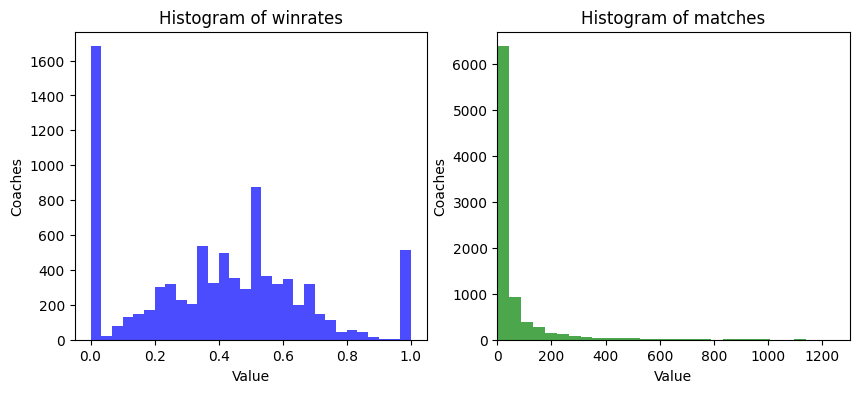

In [85]:
#Simple statistics and histograms
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(coach_winrates, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram of winrates')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Coaches')


# Plot histogram on the second subplot
axs[1].hist(coach_num_matches, bins=70, color='green', alpha=0.7)
axs[1].set_title('Histogram of matches')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Coaches')
axs[1].set_xlim([0, 1300])

# data = coach_num_matches[coach_winrates == 1]
# data2 = coach_num_matches[coach_winrates == 0]

df_descriptive = pd.DataFrame({'winrate': coach_winrates, 'total_coaches': coach_num_matches})
df_descriptive.describe()

In [94]:
#Model

# Pyro-specific imports
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam


def simple_model(obs=None):
    skill1 = pyro.sample("skill1", dist.Normal(0., 1.))
    skill2 = pyro.sample("skill2", dist.Normal(0., 1.))

    sigma1 = 1; sigma2 = 2
    perf1 = pyro.sample("perf1", dist.Normal(skill1, sigma1))
    perf2 = pyro.sample("perf2", dist.Normal(skill2, sigma2))

    with pyro.plate("data", len(obs)):
        y = pyro.sample("obs", dist.Categorical(), obs=obs)
    
    return y

In [87]:
# pyro.render_model(model, model_args=(None, None), render_distributions=True)

In [95]:
#Make guide and optimizer
auto_guide = pyro.infer.autoguide.AutoNormal(simple_model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, auto_guide, adam, elbo)

In [96]:
#Clear param store 
pyro.clear_param_store()

# These should be reset each training loop.
model = simple_model
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)


# Do gradient steps
n_steps = 1000
X_torch = torch.tensor(df_matches['team1_win'].values, dtype=torch.int32)
for step in range(n_steps):
    elbo = svi.step(X_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

ValueError: `logits` parameter must be at least one-dimensional.
Trace Shapes:  
 Param Sites:  
Sample Sites:  
  skill1 dist |
        value |
  skill2 dist |
        value |
   perf1 dist |
        value |
   perf2 dist |
        value |
Trace Shapes:
 Param Sites:
Sample Sites: